In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers, models
from keras import backend as K
import keras_tuner as kt

from keras.utils import plot_model

from sklearn.utils import shuffle
import os
import multiprocessing
from pathlib import Path
from IPython.display import Image

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-27 15:06:13.020415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

train_gen = DomainImageGenerator("prepared/train.csv", batch_size=64, img_size=(32, 32), shuffle=True, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size) # "batch_size=64, img_size=(32, 32), shuffle=True]" are the default values
val_gen = DomainImageGenerator("prepared/valid.csv", batch_size=64, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

In [3]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))

    # First Conv layer
    model.add(layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=8, max_value=64, step=8),
        kernel_size=hp.Choice('conv1_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D())

    # Optional second Conv layer
    if hp.Boolean("use_second_conv"):
        model.add(layers.Conv2D(
            filters=hp.Int('conv2_filters', min_value=8, max_value=64, step=8),
            kernel_size=hp.Choice('conv2_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    # Dropout
    model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    # Dense layer
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [4]:
# Tuner setup
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='kt_dir',
    project_name='cnn_tuning'
)

# Stop training early if not improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Reloading Tuner from kt_dir/cnn_tuning/tuner0.json


In [5]:
# Run the tuner
tuner.search(train_gen,
             validation_data=val_gen,
             epochs=20,
             callbacks=[stop_early],
             verbose=1)

Top 5 configurations:
   conv1_filters  conv1_kernel  use_second_conv  dropout_rate  dense_units  \
0             40             3             True           0.2          128   
1             16             3             True           0.2           48   
2             56             3            False           0.2           96   
3             16             3             True           0.1           64   
4             40             3             True           0.2          128   

         lr  conv2_filters  conv2_kernel  tuner/epochs  tuner/initial_epoch  \
0  0.000342           40.0           3.0            20                    7   
1  0.000230           40.0           3.0            20                    0   
2  0.000605            8.0           3.0            20                    7   
3  0.000514           32.0           3.0            20                    0   
4  0.000342           40.0           3.0             7                    0   

   tuner/bracket  tuner/round tune

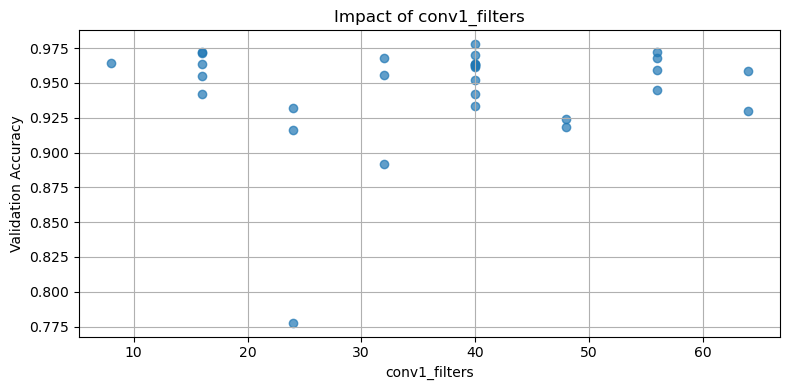

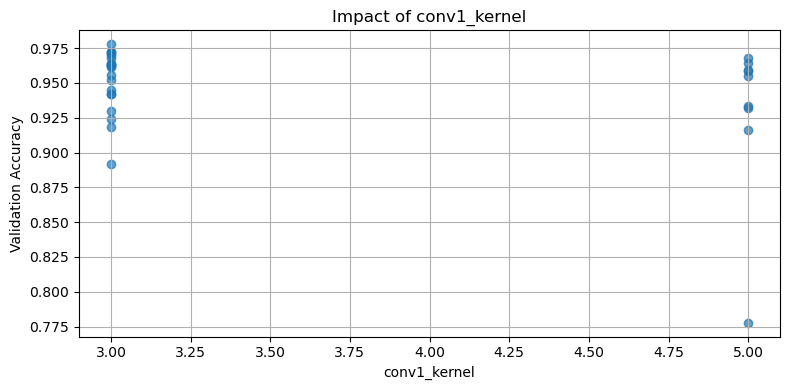

<Figure size 800x400 with 0 Axes>

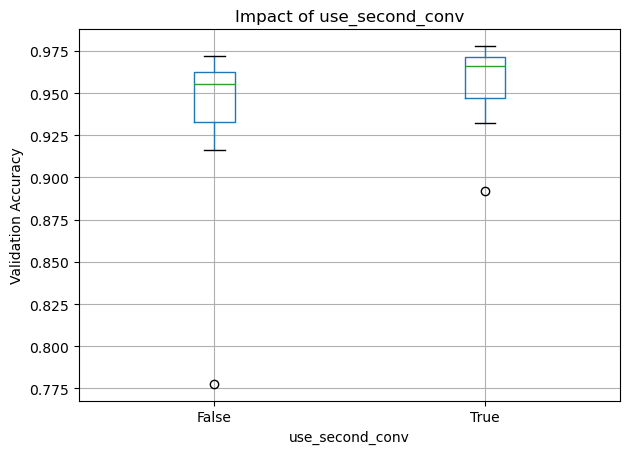

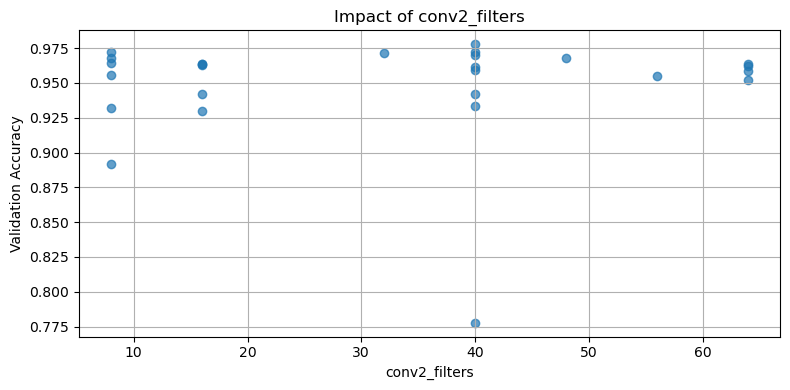

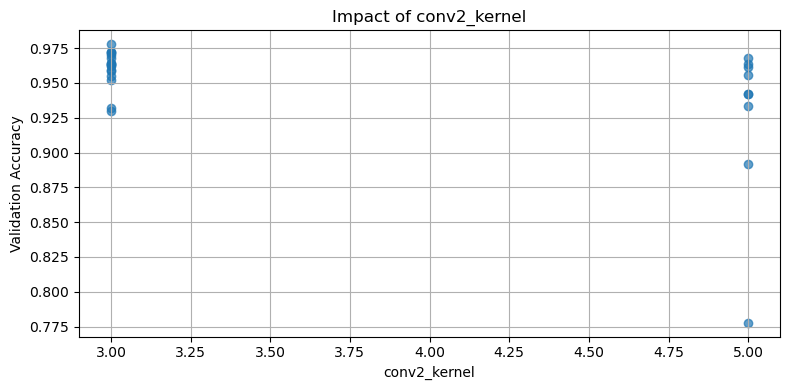

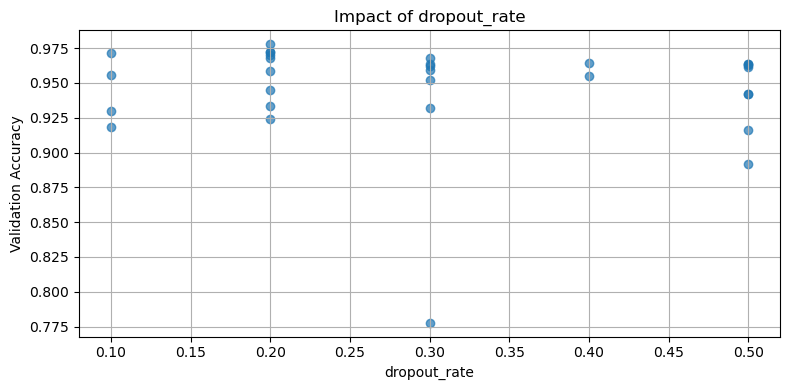

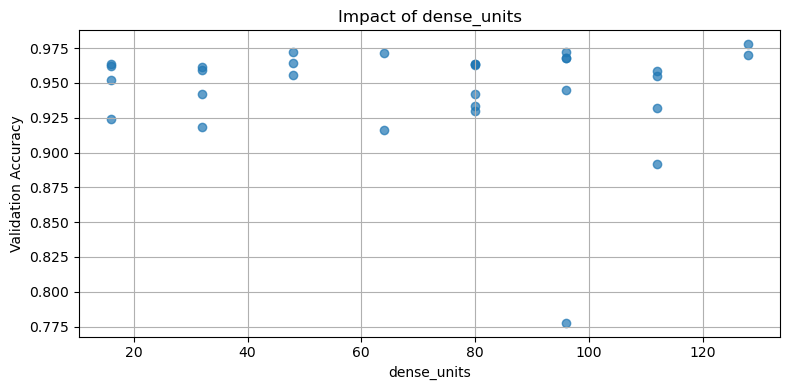

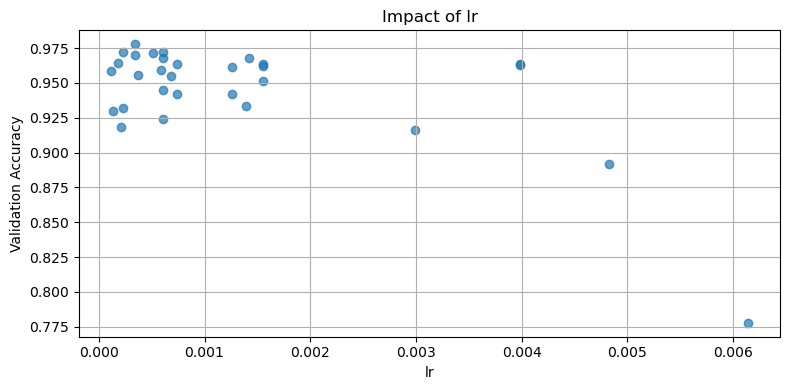

In [6]:
# Extract all trials
trials = tuner.oracle.get_best_trials(num_trials=100)
results = []

# Collect relevant metrics and hyperparameters
for t in trials:
    record = t.hyperparameters.values.copy()
    record['val_accuracy'] = t.score
    results.append(record)

# Convert to DataFrame
df = pd.DataFrame(results)

# Sort by validation accuracy
df = df.sort_values('val_accuracy', ascending=False)

# Display top rows
print("Top 5 configurations:")
print(df.head())

# Plotting helper
def plot_hp_impact(df, hp_name):
    plt.figure(figsize=(8, 4))
    if df[hp_name].dtype == 'float64' or df[hp_name].dtype == 'int64':
        plt.scatter(df[hp_name], df['val_accuracy'], alpha=0.7)
    else:
        # Categorical: use boxplot
        df.boxplot(column='val_accuracy', by=hp_name)
        plt.title('')
        plt.suptitle('')
    plt.xlabel(hp_name)
    plt.ylabel('Validation Accuracy')
    plt.title(f'Impact of {hp_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot each hyperparameter's impact
for hp in ['conv1_filters', 'conv1_kernel', 'use_second_conv', 'conv2_filters',
           'conv2_kernel', 'dropout_rate', 'dense_units', 'lr']:
    if hp in df.columns:
        plot_hp_impact(df, hp)

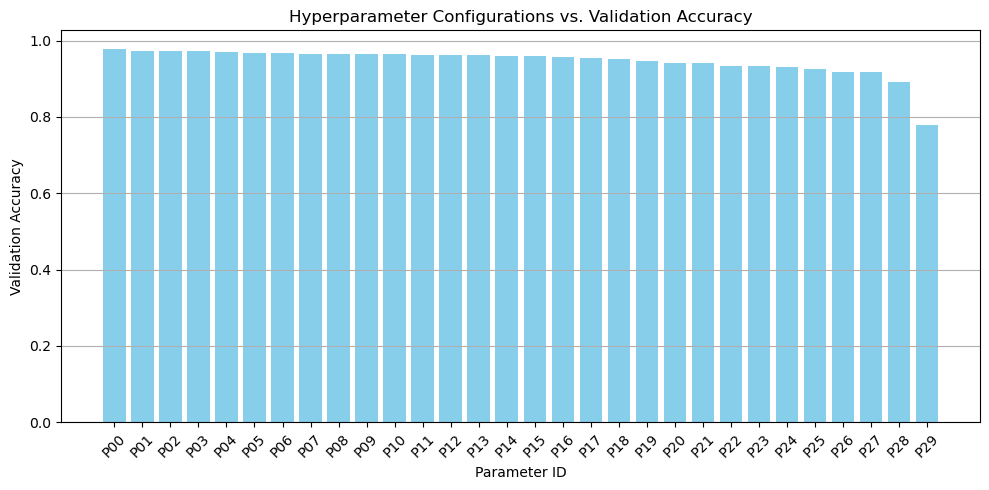

In [19]:
# Extract trial results
trials = tuner.oracle.get_best_trials(num_trials=100)
results = []
# Collect metrics and hyperparameters
for idx, t in enumerate(trials):
    record = t.hyperparameters.values.copy()
    record['val_accuracy'] = t.score
    record['param_id'] = f"P{idx:02d}"
    results.append(record)

# Convert to DataFrame
df = pd.DataFrame(results)

# Sort by accuracy (optional)
# df = df.sort_values('val_accuracy', ascending=False).reset_index(drop=True)

# Final parameter IDs after sorting
df['param_id'] = [f"P{idx:02d}" for idx in range(len(df))]

# === Plot: Validation Accuracy vs. Parameter ID ===
plt.figure(figsize=(10, 5))
plt.bar(df['param_id'], df['val_accuracy'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Validation Accuracy")
plt.xlabel("Parameter ID")
plt.title("Hyperparameter Configurations vs. Validation Accuracy")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [8]:
# Retrieve best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

Best hyperparameters:
conv1_filters: 40
conv1_kernel: 3
use_second_conv: True
dropout_rate: 0.2
dense_units: 128
lr: 0.0003420529471666411
conv2_filters: 40
conv2_kernel: 3
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020


In [9]:
# Select relevant columns
cols = [c for c in df.columns if c != 'val_accuracy']
param_table = df[cols]

# Print top 10 as Markdown (for reports)
print(param_table.head(10).to_markdown(index=False))
param_table.to_csv("build/HyperparameterSeach/hyperparameter_configs.csv", index=False)

|   conv1_filters |   conv1_kernel | use_second_conv   |   dropout_rate |   dense_units |          lr |   conv2_filters |   conv2_kernel |   tuner/epochs |   tuner/initial_epoch |   tuner/bracket |   tuner/round |   tuner/trial_id | param_id   |
|----------------:|---------------:|:------------------|---------------:|--------------:|------------:|----------------:|---------------:|---------------:|----------------------:|----------------:|--------------:|-----------------:|:-----------|
|              40 |              3 | True              |            0.2 |           128 | 0.000342053 |              40 |              3 |             20 |                     7 |               1 |             1 |               20 | P00        |
|              16 |              3 | True              |            0.2 |            48 | 0.000230349 |              40 |              3 |             20 |                     0 |               0 |             0 |              nan | P01        |
|              5

In [10]:
# Build the model with the best HPs and train it
model = tuner.hypermodel.build(best_hps)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,137 (781.79 KB)

 Trainable params: 200,137 (781.79 KB)

 Non-trainable params: 0 (0.00 B)

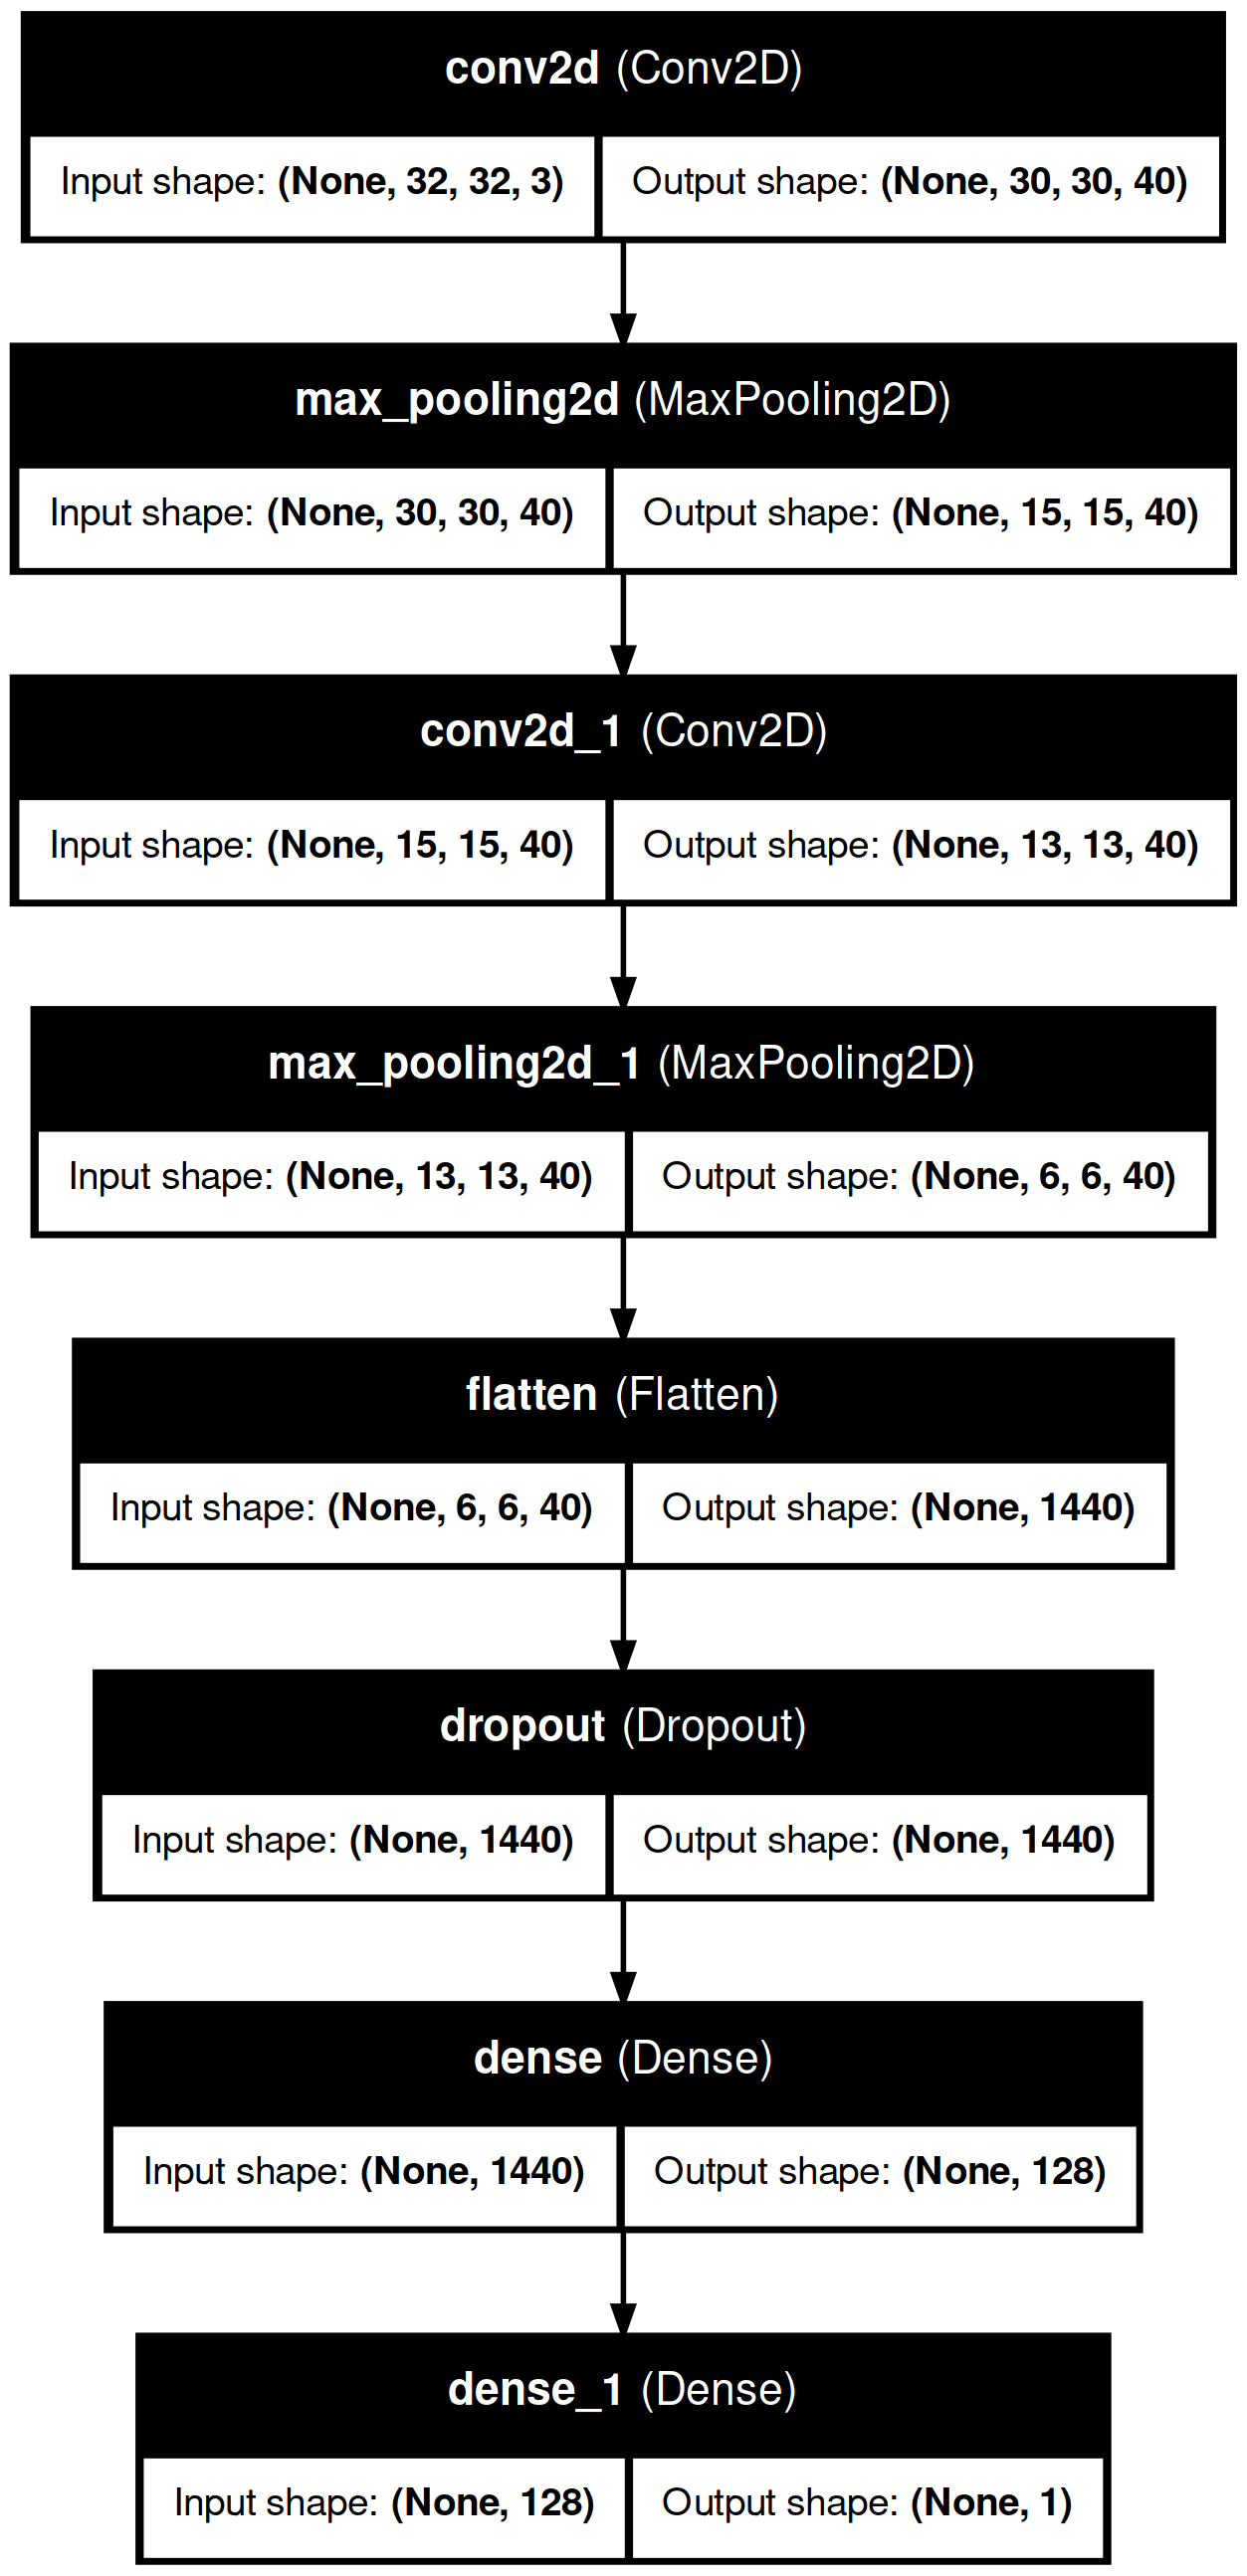

In [12]:
Path("build").mkdir(parents=True, exist_ok=True)
Path("build/HyperparameterSeach").mkdir(parents=True, exist_ok=True)

plot_model(model, to_file='build/HyperparameterSeach/Model.png', show_shapes=True, show_layer_names=True)
Image('build/HyperparameterSeach/Model.png')

In [13]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # or 'val_accuracy'
    patience=6,             # stop after n epochs without improvement
    restore_best_weights=True,  # rollback to best weights
    verbose=1
)

history = model.fit(train_gen, validation_data=val_gen, epochs=40, callbacks=[stop_early])

Epoch 1/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.8141 - loss: 0.4244 - val_accuracy: 0.9377 - val_loss: 0.1815
Epoch 2/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9228 - loss: 0.2038 - val_accuracy: 0.9475 - val_loss: 0.1501
Epoch 3/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9429 - loss: 0.1573 - val_accuracy: 0.9565 - val_loss: 0.1287
Epoch 4/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9491 - loss: 0.1427 - val_accuracy: 0.9640 - val_loss: 0.1114
Epoch 5/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9534 - loss: 0.1297 - val_accuracy: 0.9669 - val_loss: 0.0997
Epoch 6/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9606 - loss: 0.1129 - val_accuracy: 0.9672 - val_loss: 0.0982
Epoch 7/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9634 - loss: 0.1043 - val_accuracy: 0.9736 - val_loss: 0.0835
Epoch 8/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9633 -

In [14]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


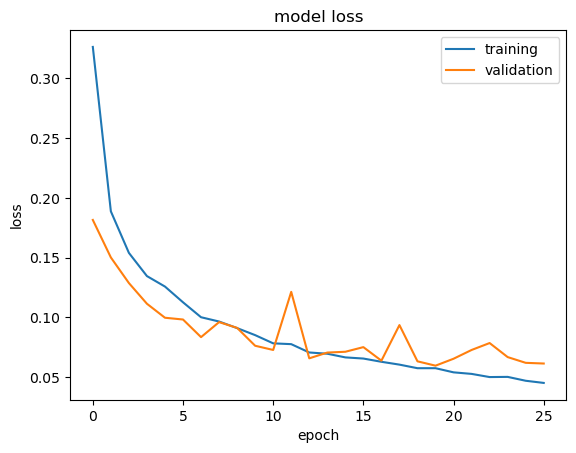

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("build/HyperparameterSeach/Loss.png")
plt.show()

In [16]:
model.save("../models/HyperparameterSeach.keras")